In [3]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[11] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [6]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


# effect of multi-peak dynamics on scoring

In [7]:
# SIR Model in homogeneous single population
# input is the number of stochastic simulations to run, the transmissibility parameter, the recovery rate, 
# population size, and number of initially infected individuals
def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        # initial conditions
        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) ) # force of infection
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu)) # recovery
            
            # update compartments
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            # create time series of compartment counts
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        # save all simulations in a dictionary
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



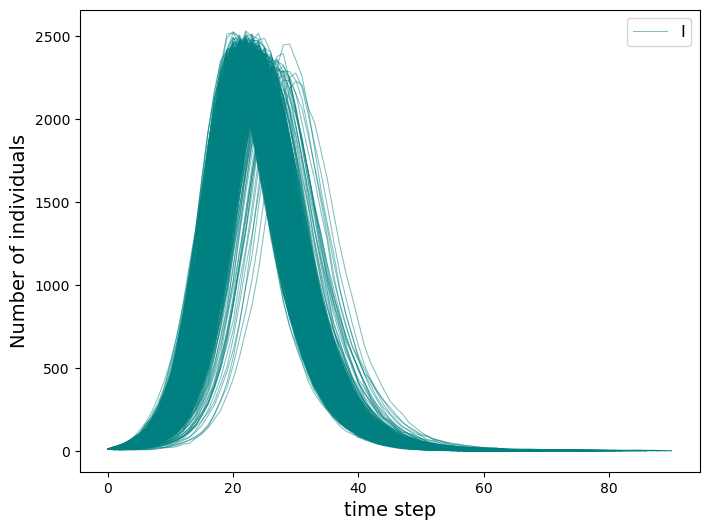

In [8]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =1000
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [9]:
# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1

In [10]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

In [12]:
# generate shifted second peak for half of the trajectories
Ishift = pd.DataFrame()
for idx in Idf.trajectory_id.unique():
    if idx>50:
        d = Idf[Idf.trajectory_id==idx]
    else:
        d = Idf[Idf.trajectory_id==idx]
        d['time'] = d['time'] + 20

        maxtime = d.time.max()
        if maxtime<60:
            while maxtime<60:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1

        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
    d= d[d.time<=60]

    Ishift = pd.concat([Ishift,d])

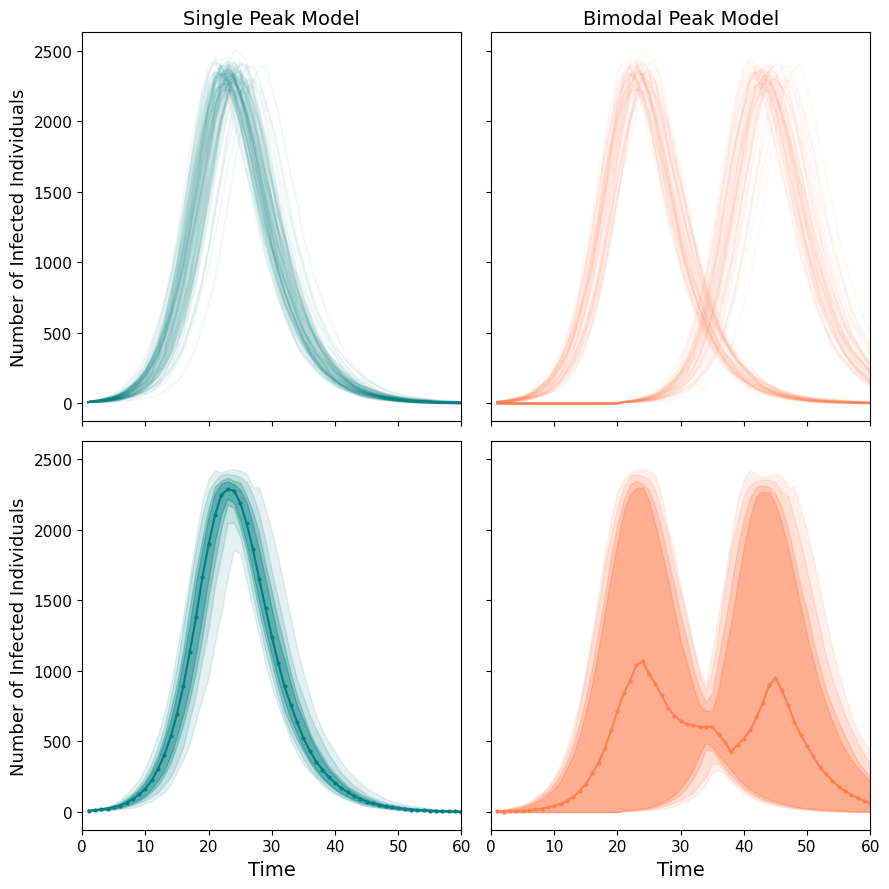

In [22]:
# visualize single and multi-peak trajectories and corresponding quantile format

Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(9,9), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.title('Single Peak Model', fontsize=14)
plt.yticks(fontsize=11)

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
plt.title('Bimodal Peak Model', fontsize=14)
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,60])

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig('../figs/SIR_bimodalpeak_viz.pdf')

plt.show()

In [23]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        if idx>50:
            d = Idf[Idf.trajectory_id==idx]
        else:
            d = Idf[Idf.trajectory_id==idx]
            d['time'] = d['time'] + 20

            maxtime = d.time.max()
            if maxtime<60:
                while maxtime<60:
                    d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                    maxtime+=1

            mintime = d.time.min()
            if mintime>1:
                while mintime>1:
                    d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                    mintime-=1
        d= d[d.time<=60]

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'time shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [24]:
# compute energy score and WIS for single and bimodal peak model
numit =500

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    
    

In [25]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id':range(numit)})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                     'trajectory_id':range(numit)})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':range(numit)})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':range(numit)})])

In [26]:
ESdf.to_pickle('../dat/ES_bimodalpeak.pkl')
WISdf.to_pickle('../dat/WIS_bimodalpeak.pkl')

In [28]:
ESdf = pd.read_pickle('../dat/ES_bimodalpeak.pkl')
WISdf = pd.read_pickle('../dat/WIS_bimodalpeak.pkl')

In [29]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='time shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='time shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

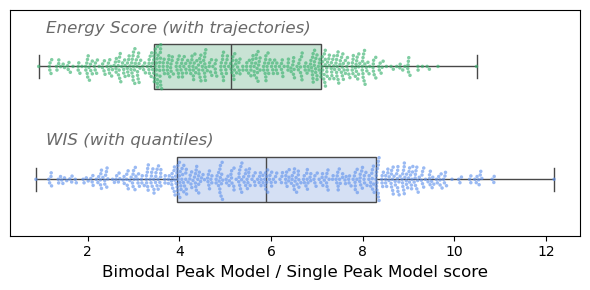

In [34]:
fig,ax = plt.subplots(figsize=(6,3.))


palette = ['mediumseagreen', 'cornflowerblue']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['Energy Score (with trajectories)', 'WIS (with quantiles)']:
    plt.text(1.1,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1
    
    
plt.xlabel('Bimodal Peak Model / Single Peak Model score',fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.savefig('../figs/bimodal_ratio_scores.pdf')

# vary the distance between bimodal peaks

In [36]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories_shift(shift,sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        if idx>50:
            d = Idf[Idf.trajectory_id==idx]
        else:
            d = Idf[Idf.trajectory_id==idx]
            d['time'] = d['time'] + shift

            maxtime = d.time.max()
            if maxtime<60:
                while maxtime<60:
                    d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                    maxtime+=1

            mintime = d.time.min()
            if mintime>1:
                while mintime>1:
                    d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                    mintime-=1
        d= d[d.time<=60]

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'time shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [37]:
# compute energy score and WIS for single and bimodal peak model
numit = 500

ES_all = pd.DataFrame()
WIS_all = pd.DataFrame()

for shift in [0,5,10,15, 20,25]:
    print(shift)
    ES_SIR = []
    ES_shift = []
    WIS_SIR = []
    WIS_shift = []

    truth = []
    for i in range(numit):

        y=np.array([])
        while y.shape[0]<60:
            # generate observation vector as single instance of SIR model
            Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
            y = np.array(Iall[0][0:60]).astype(float) 

        dftot = get_SIR_trajectories_shift(sim=800,shift=shift)

        SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
        SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 

        shiftdf = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
        shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

        # calculate scores
        ES_SIR.append(energyscore(SIR_X ,y))
        ES_shift.append(energyscore(shift_X,y))
        WIS_SIR.append(WIS(SIR_X,y))
        WIS_shift.append(WIS(shift_X,y))


    ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id': list(range(len(ES_SIR)))})
    ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                         'trajectory_id':list(range(len(ES_shift)))})])
    
    ESdf['shift'] = shift

    WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(range(len(WIS_SIR)))})
    WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                           'trajectory_id':list(range(len(WIS_shift)))})])
    WISdf['shift'] = shift
    
    ES_all = pd.concat([ES_all,ESdf])
    WIS_all = pd.concat([WIS_all,WISdf])

0
5
10
15
20
25


In [38]:
ES_all.to_pickle('../dat/ES_bimodalpeak_varyshift.pkl')
WIS_all.to_pickle('../dat/WIS_bimodalpeak_varyshift.pkl')

In [39]:
ES_all = pd.read_pickle('../dat/ES_bimodalpeak_varyshift.pkl')
WIS_all = pd.read_pickle('../dat/WIS_bimodalpeak_varyshift.pkl')

In [40]:
dfratio_all = pd.DataFrame()
for shift in [0,5,10,15,20,25]:
    df_ES = ES_all[ES_all['shift']==shift]
    df_WIS = WIS_all[WIS_all['shift']==shift]
    
    dfSIR = df_ES[df_ES.Model=='SIR']
    dfshifted = df_ES[df_ES.Model=='time shifted SIR'].rename(columns={'value':'value_shifted'})

    dfratio = dfSIR.merge(dfshifted,on=['trajectory_id','shift'])
    dfratio['ratio'] = dfratio['value_shifted'] / dfratio['value']
    dfratio['score'] = 'Energy Score'

    dfSIR = df_WIS[df_WIS.Model=='SIR']
    dfshifted = df_WIS[df_WIS.Model=='time shifted SIR'].rename(columns={'value':'value_shifted'})

    dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id','shift'])
    dfratio_WIS['ratio'] = dfratio_WIS['value_shifted'] / dfratio_WIS['value']
    dfratio_WIS['score'] = 'WIS'

    dfratio = pd.concat([dfratio,dfratio_WIS])
    dfratio['shift'] = shift
    
    dfratio_all = pd.concat([dfratio_all, dfratio])

In [148]:
dfratio_all

,Model_x,value,trajectory_id,shift,Model_y,value_shifted,ratio,score
0,SIR,328.718008,0,0,time shifted SIR,328.718008,1.000000,Energy Score
1,SIR,458.094258,1,0,time shifted SIR,458.094258,1.000000,Energy Score
2,SIR,636.697783,2,0,time shifted SIR,636.697783,1.000000,Energy Score
3,SIR,536.987837,3,0,time shifted SIR,536.987837,1.000000,Energy Score
4,SIR,464.374209,4,0,time shifted SIR,464.374209,1.000000,Energy Score
...,...,...,...,...,...,...,...,...
195,SIR,2181.851411,195,25,time shifted SIR,14498.227672,6.644920,WIS
196,SIR,2896.181013,196,25,time shifted SIR,16274.846728,5.619416,WIS
197,SIR,3551.841167,197,25,time shifted SIR,15971.973546,4.496815,WIS
198,SIR,2845.868211,198,25,time shifted SIR,15097.408035,5.305027,WIS


Text(0, 0.5, 'Two Peak Model / Single Peak Model Score')

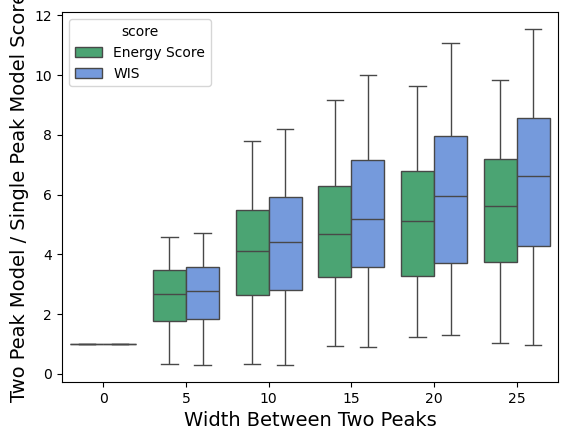

In [41]:
plt.style.use('default')
df = dfratio_all
palette = ['mediumseagreen', 'cornflowerblue']
sns.boxplot(x='shift',y='ratio',data=df,hue='score',showfliers=False,palette=palette)
plt.xlabel('Width Between Two Peaks', fontsize=14)
plt.ylabel('Two Peak Model / Single Peak Model Score', fontsize=14)


Text(0, 0.5, 'Median Two Peak Model / Single \n Peak Model Score')

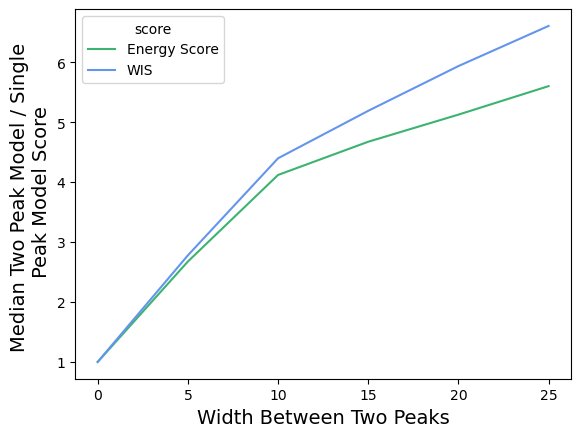

In [42]:
df = dfratio_all.groupby(['shift','score'])['ratio'].median().reset_index()

sns.lineplot(x='shift', y='ratio',data=df,hue='score',palette=palette,)
#plt.plot(df['shift'],df['ratio'],)
#plt.yscale('log')

plt.xlabel('Width Between Two Peaks', fontsize=14)
plt.ylabel('Median Two Peak Model / Single \n Peak Model Score', fontsize=14)

#plt.xlim([0, None])
#plt.ylim([0.9,1.5])

Text(0, 0.5, 'Median Difference in Two Peak / Single \n Peak Model Ratio (WIS-Energy Score)')

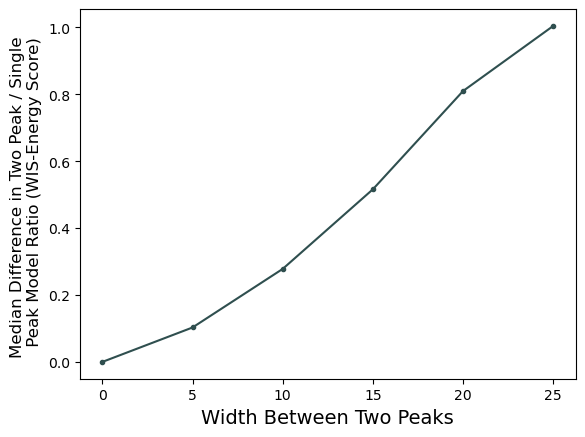

In [43]:
# difference of the medians

df = dfratio_all.groupby(['shift','score'])['ratio'].median().reset_index()

dfWIS = df[df.score=='WIS'].rename(columns={'ratio':'WISratio'}).drop(columns='score')
dfES = df[df.score=='Energy Score'].rename(columns={'ratio':'ESratio'}).drop(columns='score')

dfdiff = dfES.merge(dfWIS, on=['shift'])

dfdiff['diff'] = dfdiff['WISratio'] - dfdiff['ESratio']

plt.plot(dfdiff['shift'], dfdiff['diff'], '.-', color='darkslategray')

plt.xlabel('Width Between Two Peaks', fontsize=14)
plt.ylabel('Median Difference in Two Peak / Single \n Peak Model Ratio (WIS-Energy Score)', fontsize=12)



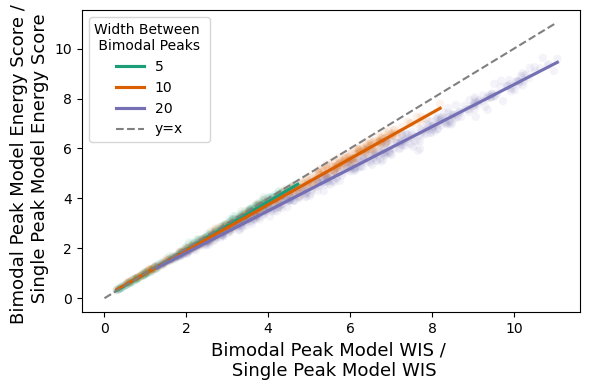

In [97]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

dfes = dfratio_all[dfratio_all.score=='Energy Score']
dfes = dfes[['trajectory_id', 'shift', 'ratio']].rename(columns={'ratio':'esratio'})

dfwis = dfratio_all[dfratio_all.score=='WIS']
dfwis = dfwis[['trajectory_id', 'shift', 'ratio']].rename(columns={'ratio':'wisratio'})

df = dfes.merge(dfwis, on=['trajectory_id', 'shift'])
df = df[df['shift'].isin([20,10,5])]
sns.scatterplot(x='wisratio', y='esratio', hue='shift', data=df,palette='Dark2',alpha=.08,legend=False)


# Plot regression line per shift
shifts = df['shift'].unique()
palette = dict(zip(shifts, sns.color_palette('Dark2', len(shifts))))

for shift in shifts:
    sub = df[df['shift'] == shift]
    sns.regplot(x='wisratio', y='esratio', data=sub, label=shift,
        scatter=False, ax=ax, color=palette[shift], ci=None)



plt.plot(range(12), range(12),'--',color='gray',label='y=x')

plt.xlabel('Bimodal Peak Model WIS / \n Single Peak Model WIS', fontsize=13)
plt.ylabel('Bimodal Peak Model Energy Score / \n Single Peak Model Energy Score', fontsize=13)

plt.legend(title='Width Between \n Bimodal Peaks')

plt.tight_layout()

plt.savefig('../figs/bimodal_scoreratio_correlation.pdf')